In [1]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph

In [2]:
# script parameters
MAIN_DIR_PATH = "/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint"
DATA_DIR_NAME = "data"
IMAGES_DIR_NAME = "images"
LABELS_DIR_NAME = "labels"
SUPERPIXELS_DIR_NAME = "superpixels"

In [3]:
# globals
DATA_DIR_PATH = f"{MAIN_DIR_PATH}/{DATA_DIR_NAME}"
IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/{IMAGES_DIR_NAME}"
LABELS_DIR_PATH = f"{DATA_DIR_PATH}/{LABELS_DIR_NAME}"
SUPERPIXELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_DIR_NAME}"

In [ ]:
# utils
def show_2d_image_from_3d_image(image_3d, index_of_2d_image):
    plt.figure(figsize = (20,20))
    plt.imshow(image_3d[:,:,index_of_2d_image], cmap='gray')
    plt.show()

In [4]:
# read data
def read_binary_data_3D(file_name, image_size, image_count, voxel_bytes, signed='Y', byte_order='BE'):
    if voxel_bytes == 2:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint16)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int16)
    elif voxel_bytes == 1:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint8)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int8)
    else:
        print('Wrong number of bytes per voxel')
        return

    f = open(file_name, "rb")
    for i in range(0, image_count):
        for j in range(0, image_size):
            for k in range(0, image_size):
                byte = f.read(voxel_bytes)
                if voxel_bytes == 2:
                    if byte_order == 'BE':
                        a = 256 * byte[0] + byte[1]
                    else:
                        a = byte[0] + 256 * byte[1]
                else:
                    a = byte[0]
                d[j,k,i] = a
    f.close()
    return d

In [5]:



def create_rag_on_labels_image(labels, superpixels, rag, file_info, image_number):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))
    ax.axis('off')
    graph_image_path = f"{DATA_DIR_PATH}/rags/{file_info.patient_id}/rag_{image_number}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.png"
    file = open(graph_image_path, "w")
    file.close()
    lc = skigraph.show_rag(labels, rag, superpixels, img_cmap='pink', edge_cmap='viridis', ax=ax)
    fig.savefig(graph_image_path)
    plt.close(fig) 

FileInfo = collections.namedtuple('FileInfo', ['name', 'patient_id', 'height', 'width', 'image_count', 'voxel_bytes'])

def process_all_3D_images_from_directory(images_dir_path, labels_dir_path, superpixels_dir_path):
    file_names = os.listdir(labels_dir_path)
    rags = {i: list() for i in range(1, len(file_names) + 1)}

    for file_name in file_names:
        unprocessed_file_info = file_name.split("_")[:-1]
        unprocessed_file_info[1:] = [int(unprocessed_file_info[i]) for i in range(1, len(unprocessed_file_info))]
        file_info = FileInfo(*unprocessed_file_info)
        print(f"Processing file: {file_info.patient_id}")
        
        labels_file = read_binary_data_3D(
            f"{labels_dir_path}/{file_name}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        image_file = read_binary_data_3D(
            f"{images_dir_path}/STIR_{file_info.patient_id}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.raw",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='BE'
        )
        superpixels_file = read_binary_data_3D(
            f"{superpixels_dir_path}/1000SuperPixelMeanValueTPS_{file_info.patient_id}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.raw",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        
        for labels_index in range(file_info.image_count):
            print(f"Processing sub images: {labels_index}/{file_info.image_count}")
            labels = labels_file[:,:,labels_index]
            img = image_file[:,:,labels_index]
            rag = skigraph.rag_mean_color(img, labels)
            rags[file_info.patient_id].append(rag)
            superpixels = superpixels_file[:,:,labels_index]
            create_rag_on_labels_image(labels, superpixels, rag, file_info, labels_index + 1)


Processing file: 12
Processing sub images: 0/18


FileNotFoundError: [Errno 2] No such file or directory: '/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/data/rags/12/rag_1_400_400_18_2_.png'

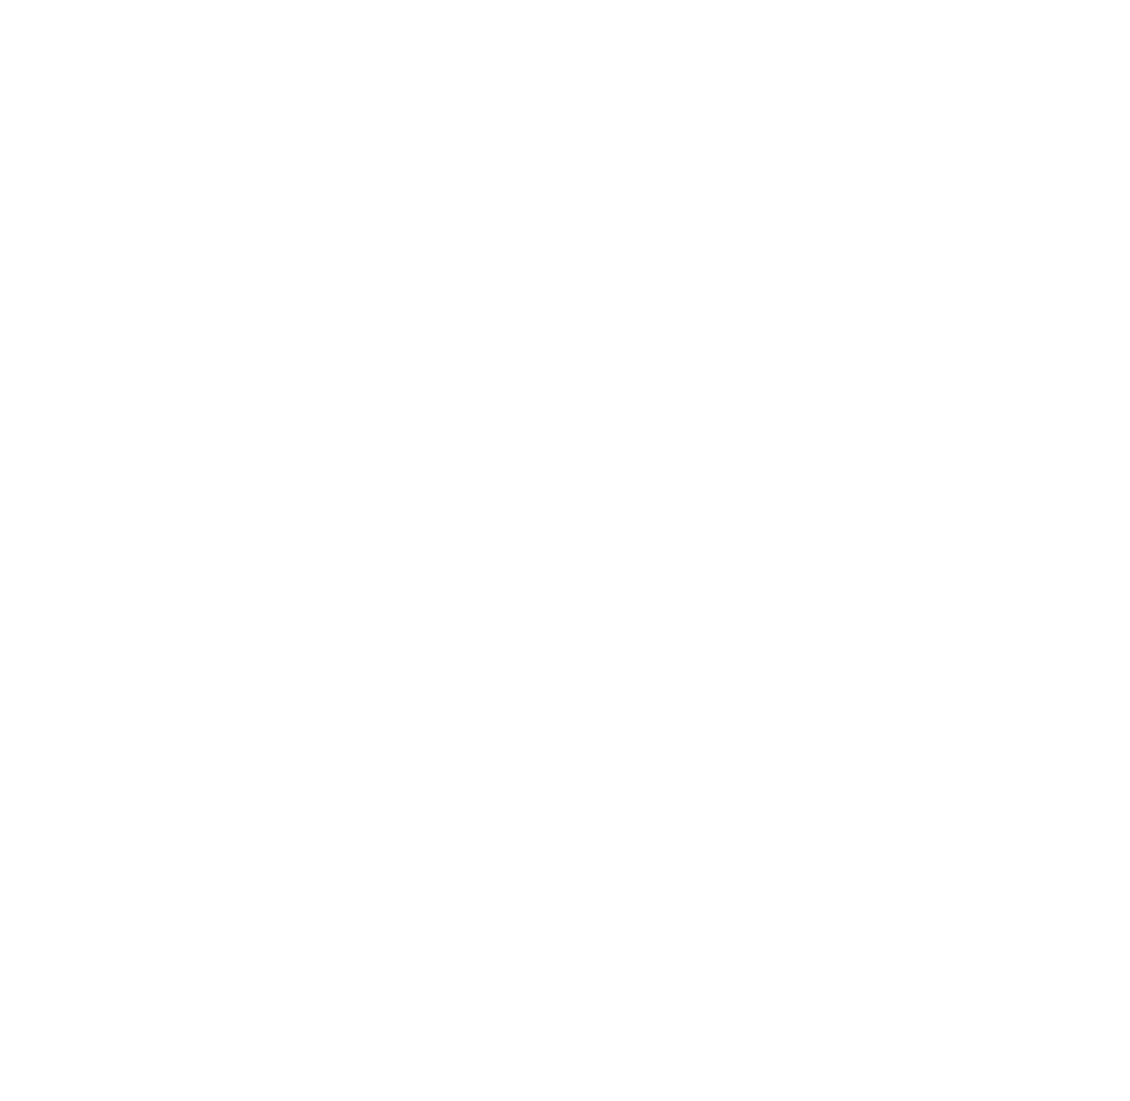

In [6]:
process_all_3D_images_from_directory(IMAGES_DIR_PATH, LABELS_DIR_PATH, SUPERPIXELS_DIR_PATH)